<a href="https://colab.research.google.com/github/riszwinger/tensorflow_cert/blob/main/basic/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
import tensorflow as tf
import numpy as np
import os
import shutil
import re
import string
import matplotlib.pyplot as plt
print('GPU is ', 'avaliable' if tf.config.list_physical_devices('GPU') else 'not avaliable')
print('TF Version: {}'.format(tf.__version__))

GPU is  avaliable
TF Version: 2.5.0


In [118]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

data_dir=tf.keras.utils.get_file(fname='aclImdb_v1',origin=url,untar=True)
print(data_dir)

/root/.keras/datasets/aclImdb_v1


In [119]:
!ls /root/.keras/datasets/aclImdb


imdbEr.txt  imdb.vocab	README	test  train


In [120]:
!ls /root/.keras/datasets/aclImdb/train


labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [121]:
train_dir=os.path.join(os.path.dirname(data_dir),'aclImdb','train')
test_dir=os.path.join(os.path.dirname(data_dir),'aclImdb','test')

In [122]:
remove_dir=os.path.join(train_dir,'unsup')
shutil.rmtree(remove_dir)

In [146]:
seq_length=250
max_features=10000

train_ds=tf.keras.preprocessing.text_dataset_from_directory(directory=train_dir,seed=123,validation_split=0.2,subset='training')
valid_ds=tf.keras.preprocessing.text_dataset_from_directory(directory=train_dir,seed=123,validation_split=0.2,subset='validation')
test_ds=tf.keras.preprocessing.text_dataset_from_directory(directory=test_dir,seed=123,batch_size=1)



Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [147]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [148]:
train_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [149]:
for text_val,label_val in train_ds.take(1):
  print(type(text_val))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [150]:
for text_val,label_val in train_ds.take(1):
  print((label_val,text_val))

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int32)>, <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Jason Bourne sits in a dusty room in with blood on his hands, trying to make sense of what he\'s just done. Meanwhile, a CIA chief in NYC outlines the agency\'s response to what\'s just happened on screen. An American flag stands proudly on the centre of his desk in the foreground of the shot, but as he speaks, it slips out of focus as his plan veers into morally dubious territory, as if it doesn\'t want to be associated with the course of action the government man decides is necessary in the interests of national security.<br /><br />This shot effectively captures the mood of the film. As well as portraying Bourne\'s quest to find out how he became Jason Bourne, Ultimatum is also an examination of the human costs of the measures taken to protect us in the intere

In [151]:
for text_val,label_val in train_ds.take(1):
  for i in range(3):
    print((label_val[i].numpy(),text_val[i].numpy()))
    #print((text_val[i].shape))

(0, b'<br /><br />Back in his youth, the old man had wanted to marry his first cousin, but his family forbid it. Many decades later, the old man has raised three children (two boys and one girl), and allows his son and daughter to marry and have children. Soon, the sister is bored with brother #1, and jumps in the bed of brother #2.<br /><br />One might think that the three siblings are stuck somewhere on a remote island. But no -- they are upper class Europeans going to college and busy in the social world.<br /><br />Never do we see a flirtatious moment between any non-related female and the two brothers. Never do we see any flirtatious moment between any non-related male and the one sister. All flirtatious moments are shared between only between the brothers and sister.<br /><br />The weakest part of GLADIATOR was the incest thing. The young emperor Commodus would have hundreds of slave girls and a city full of marriage-minded girls all over him, but no -- he only wanted his sister?

## Standardize --> Tokenize -- > Vectorize 

In [152]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [153]:
re.escape(string.punctuation)

'!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~'

In [154]:
'[%s]' % re.escape(string.punctuation)

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]'

In [155]:
def custom_standarize(input_val):
  lower_case=tf.strings.lower(input_val)
  remove_special=tf.strings.regex_replace(lower_case,'<br />','')
  return tf.strings.regex_replace(remove_special,'[%s]' % re.escape(string.punctuation),'')

In [156]:
inp_str='<br /><br />Back in his youth, the old man had wanted to marry his first cousin, but his family forbid it. Many decades later, the old man has raised three children (two boys and one girl), and allows his son and daughter to marry and have children. '
custom_standarize(inp_str).numpy()

b'back in his youth the old man had wanted to marry his first cousin but his family forbid it many decades later the old man has raised three children two boys and one girl and allows his son and daughter to marry and have children '

In [157]:
vectorize_layer=tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=max_features,standardize=custom_standarize,output_sequence_length=seq_length)

In [158]:
texts,lbls=next(iter(train_ds))
type(texts)

tensorflow.python.framework.ops.EagerTensor

In [159]:
first_txt=texts[0]
first_txt

<tf.Tensor: shape=(), dtype=string, numpy=b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor 

In [160]:
first_txt.numpy()

b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor of Venezuela didn't believe the media. The

In [161]:
vectorize_layer(first_txt)

InvalidArgumentError: ignored

In [162]:
tf.expand_dims(first_txt,axis=-1)

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But

In [163]:
vectorize_layer.get_vocabulary()[:10]

IndexError: ignored

In [164]:
vectorize_layer(tf.expand_dims(first_txt,axis=-1))

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]])>

In [165]:
train_text=train_ds.map(lambda x ,y: x)

In [166]:
vectorize_layer.adapt(train_text)

In [167]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

In [169]:
first_txt.numpy()

b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor of Venezuela didn't believe the media. The

In [168]:
vectorize_layer(tf.expand_dims(first_txt,axis=-1))

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  10,  676,  158, 1412,  962,   20,    1,    7,    4,  768,    1,
           5,    2,  664,    5, 1809,   77,    6, 3042, 8554,  302,  217,
          65,    1,   13, 8402,    8,    4,    1, 2188,    8, 6825,   24,
        7397,   13,    6,    1,    2,  768, 3340, 3672,   36,    2,  955,
         759,  797,    6,    2, 3461,  339,   27, 3921, 2060, 8011, 5767,
        5627,    8,    1, 3956,   27, 1345,    1, 6337, 3836,    6,    2,
           1,    6, 1656,    2, 1187,   16,  962,   27, 6586,   44,    1,
           3,  272,   54,  153,  962,    1,   18,    9,   13,   24, 1183,
        6840,   20, 3340, 1145, 9978,   12,  183,   88,    8, 1137,   15,
           2, 3458, 9612,    8, 3809,  136, 2524,   19, 1346, 2560,    1,
           3,    1,    1,   66,    1, 6345,  979,    2, 8952, 5388,   42,
          24, 1007, 5528,    4, 3600, 7342, 5801,   13,    1,   15,    2,
        3948, 2698, 6345,   13, 1798,    3,    1,   44,    5,   

In [182]:
def vectorize_text(text,lbl):
  text=tf.expand_dims(text,axis=-1)
  return vectorize_layer(text),lbl


In [183]:
train_ds_r1=train_ds.map(vectorize_text)
valid_ds_r1=valid_ds.map(vectorize_text)
test_ds_r1=test_ds.map(vectorize_text)

In [184]:
next(iter(train_ds_r1))

(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
 array([[  10,   17,    7, ...,    0,    0,    0],
        [ 317,  742,    2, ...,    0,    0,    0],
        [3372,    5,  195, ...,   61,    4,    1],
        ...,
        [ 764,    6,  129, ...,    0,    0,    0],
        [5395,    1,    1, ...,   66,    1,    5],
        [  40,  624,   20, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1], dtype=int32)>)

## Performance Tuning

In [185]:
AUTOTUNE= tf.data.AUTOTUNE
train_ds_r1=train_ds_r1.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds_r1=valid_ds_r1.cache().prefetch(buffer_size=AUTOTUNE)
test_ds_r1=test_ds_r1.cache().prefetch(buffer_size=AUTOTUNE)

In [186]:
embedding_dim=16

model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(max_features+1,embedding_dim))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [187]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [188]:
history=model.fit(train_ds_r1,epochs=10,validation_data=valid_ds_r1)

Epoch 1/10
625/625 [==============================] - 12s 15ms/step - loss: 0.6658 - accuracy: 0.5044 - val_loss: 0.6179 - val_accuracy: 0.5078
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5529 - accuracy: 0.6567 - val_loss: 0.5026 - val_accuracy: 0.7114
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4496 - accuracy: 0.7865 - val_loss: 0.4264 - val_accuracy: 0.7920
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3827 - accuracy: 0.8360 - val_loss: 0.3817 - val_accuracy: 0.8182
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3400 - accuracy: 0.8585 - val_loss: 0.3543 - val_accuracy: 0.8346
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3090 - accuracy: 0.8745 - val_loss: 0.3357 - val_accuracy: 0.8450
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2851 - accuracy: 0.8831 - val_loss: 0.3226 - val_accuracy: 0.8526
Epoc

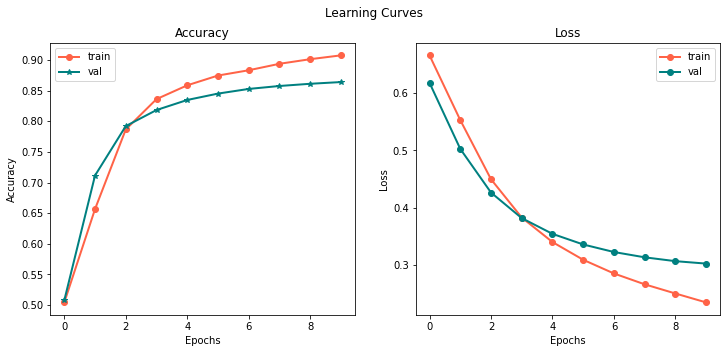

In [196]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,2,figsize=(12,5))
epochs=range(len(history.history['accuracy']))

ax[0].plot(epochs,history.history['accuracy'],label='train',lw=2,marker='o',color='tomato')
ax[0].plot(epochs,history.history['val_accuracy'],label='val',lw=2,marker='*',color='teal')
ax[0].set_title('Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend()


ax[1].plot(epochs,history.history['loss'],label='train',lw=2,marker='o',color='tomato')
ax[1].plot(epochs,history.history['val_loss'],label='val',lw=2,marker='o',color='teal')
ax[1].set_title('Loss')
ax[1].legend()

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
plt.suptitle('Learning Curves')
plt.show()

In [197]:
model.evaluate(test_ds_r1)

25000/25000 [==============================] - 56s 2ms/step - loss: 0.3195 - accuracy: 0.8512


[0.31945502758026123, 0.8511999845504761]

## Adding vectorization step as part of the model

In [199]:
export_model=tf.keras.models.Sequential([
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')]
)

In [200]:
export_model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
export_model.evaluate(test_ds)

25000/25000 [==============================] - 66s 3ms/step - loss: 0.3195 - accuracy: 0.8674


[0.31945502758026123, 0.8674399852752686]

## Raw Input

In [210]:
example=["The movie was great! and good , best, better , golden, amazing, happy ",
         "The movie was just ok",
         "The movie was awful, bad, terrible, wrost, pathetic."]
export_model.predict(example)

array([[0.84408414],
       [0.40890223],
       [0.0810353 ]], dtype=float32)